In [9]:
# Enhanced Comparison Analysis - Checkout Visits, Pop-up Modal, and Purchase Events
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the CSV file
df = pd.read_csv('analytics.csv')

In [10]:
# Examine the structure of the data
print(f"Dataset shape: {df.shape}")
print("\nColumn names:")
print(df.columns.tolist())
print("\nEvent types:")
print(df['type'].value_counts())
print("\nFirst few rows:")
df.head()

Dataset shape: (13634, 9)

Column names:
['id', 'type', 'url', 'payload', 'user_id', 'session_id', 'received_at', 'created_at', 'domain']

Event types:
type
time-spent                            11711
page-view                              1187
from-directs                            220
on-onboarding                           181
checkout                                 54
add-to-cart                              54
from-directs-cta                         44
uninstall                                32
open-popup                               31
enforce_wait_modal_shown                 27
active                                   19
welcome-modal-seen                       18
questionary-popup                        15
enforce_wait_canceled                    12
enforce_wait_info_expanded               10
questionary-closed                        7
open-options                              4
enforce_wait_permit_valid_on_click        4
place-order                               2
questio

,id,type,url,payload,user_id,session_id,received_at,created_at,domain
0,19500,from-directs,www.lessextension.com/,"""anticonsumption""",less-website,none,2025-03-27T01:06:50.771229+00:00,2025-03-27T01:06:50.072+00:00,lessextension.com
1,19501,from-directs,www.lessextension.com/,"""chrome_extensions""",less-website,none,2025-03-27T04:40:08.182539+00:00,2025-03-27T04:40:08.386+00:00,lessextension.com
2,19502,from-directs,www.lessextension.com/,"""chrome_extensions""",less-website,none,2025-03-27T04:40:12.087957+00:00,2025-03-27T04:40:11.03+00:00,lessextension.com
3,19503,from-directs,www.lessextension.com/,"""shoppingaddiction""",less-website,none,2025-03-27T06:05:28.66007+00:00,2025-03-27T06:05:28.463+00:00,lessextension.com
4,19504,from-directs,www.lessextension.com/,"""kua""",less-website,none,2025-03-27T07:16:26.763114+00:00,2025-03-27T07:16:25.837+00:00,lessextension.com


# Shopping Session Analysis

We'll analyze user behavior after adding items to cart. The possible paths are:

1. Add to cart → Never proceed to checkout
2. Add to cart → Checkout → Don't place order
3. Add to cart → Checkout → See enforce_wait_modal → Wait 3 hours → Place order
4. Add to cart → Checkout → See enforce_wait_modal → Disable extension → Place order

We'll define a unique shopping session by each combination of `user_id` and `domain`.

In [11]:
# Define shopping sessions by user_id and domain

# Create a unique session ID by combining user_id and domain
df['session_id'] = df['user_id'] + '_' + df['domain']

# Count unique sessions
unique_sessions = df['session_id'].nunique()
print(f"Total unique shopping sessions: {unique_sessions}")

# Extract sessions that have at least one add-to-cart event
cart_sessions = df[df['type'] == 'add-to-cart']['session_id'].unique()
print(f"Sessions with at least one add-to-cart event: {len(cart_sessions)}")

Total unique shopping sessions: 160
Sessions with at least one add-to-cart event: 18


In [12]:
# Function to determine the path for each session
def analyze_session_paths(df):
    # Initialize dictionaries to store session paths and counts
    path_counts = {}
    
    # Get all unique session IDs
    # Distinguish sessions by unique user_id and domain
    sessions = df[['user_id', 'domain']].drop_duplicates().apply(lambda row: f"{row['user_id']}_{row['domain']}", axis=1).values

    successful_blockings = []
    
    for session in sessions:
        # Filter data for this session
        user_id, domain = session.split('_', 1)
        session_data = df[(df['user_id'] == user_id) & (df['domain'] == domain)].sort_values('received_at')
        
        # Check for add-to-cart event
        has_add_to_cart = 'add-to-cart' in session_data['type'].values

        # Check for various events
        has_checkout = 'checkout' in session_data['type'].values
        has_modal = 'enforce_wait_modal_shown' in session_data['type'].values
        has_purchase = 'place-order' in session_data['type'].values

        deactivated = False
        uninstall = False
        
        # Check for extension deactivation after modal
        if has_modal:
            modal_time = session_data[session_data['type'] == 'enforce_wait_modal_shown']['created_at'].iloc[0]
            # Look for 'active' events where active=false after modal time
            deactivated = len(df[
                (df['user_id'] == user_id) & 
                (df['type'] == 'active') & 
                (df['created_at'] > modal_time) &
                (pd.to_datetime(df['created_at'], format="mixed") <= (pd.to_datetime(modal_time, format="mixed") + pd.Timedelta(minutes=10)))
            ]) > 0

            # Only consider uninstall events within 10 minutes after modal shown
            uninstall = len(df[
                (df['user_id'] == user_id) & 
                (df['type'] == 'uninstall') & 
                (df['created_at'] > modal_time)
                & (pd.to_datetime(df['created_at'], format="mixed") <= (pd.to_datetime(modal_time, format="mixed") + pd.Timedelta(minutes=50)))
            ]) > 0

        str_to_add = []

        if has_add_to_cart:
            str_to_add.append("add")
        
        if has_checkout:
            str_to_add.append("cart")

        if has_modal:
            str_to_add.append("modal")

        if has_purchase:
            str_to_add.append("purchase")

        if deactivated:
            str_to_add.append("disable")

        if uninstall:
            str_to_add.append("uninstall")
        
        if has_modal and not uninstall and not deactivated and not has_purchase:
            str_to_add.append("abandon")

        if len(str_to_add) == 0:
            continue

        path = "_".join(str_to_add)

        if path not in path_counts:
            path_counts[path] = 0
        
        # Store path for this session
        path_counts[path] += 1

    return path_counts, successful_blockings

# Analyze session paths
path_counts, successful_blockings = analyze_session_paths(df)

# change key of add_modal to add_checkout_modal
path_counts['add_cart'] += path_counts.pop('cart')
path_counts['add_cart_modal_disable'] += path_counts.pop('cart_modal_disable')
path_counts['add_cart_modal_abandon'] += path_counts.pop('cart_modal_abandon')
path_counts['add_cart_modal_abandon'] += path_counts.pop('add_modal_abandon')
path_counts['add_cart_abandon'] = path_counts.pop('add_cart')
path_counts['add_abandon'] = path_counts.pop('add')

print("Successful blockings:")
for blocking in successful_blockings:
    print(blocking)

# Display results
for path, count in path_counts.items():
    print(f"{path}: {count} sessions")


Successful blockings:
add_cart_modal_uninstall: 3 sessions
add_cart_modal_purchase: 2 sessions
add_cart_modal_abandon: 4 sessions
add_cart_modal_disable: 3 sessions
add_cart_abandon: 16 sessions
add_abandon: 1 sessions


In [13]:
# print event id = 21170 and the prior 100 events
event_id = 21170
# print event id = 21170 and the prior 100 events

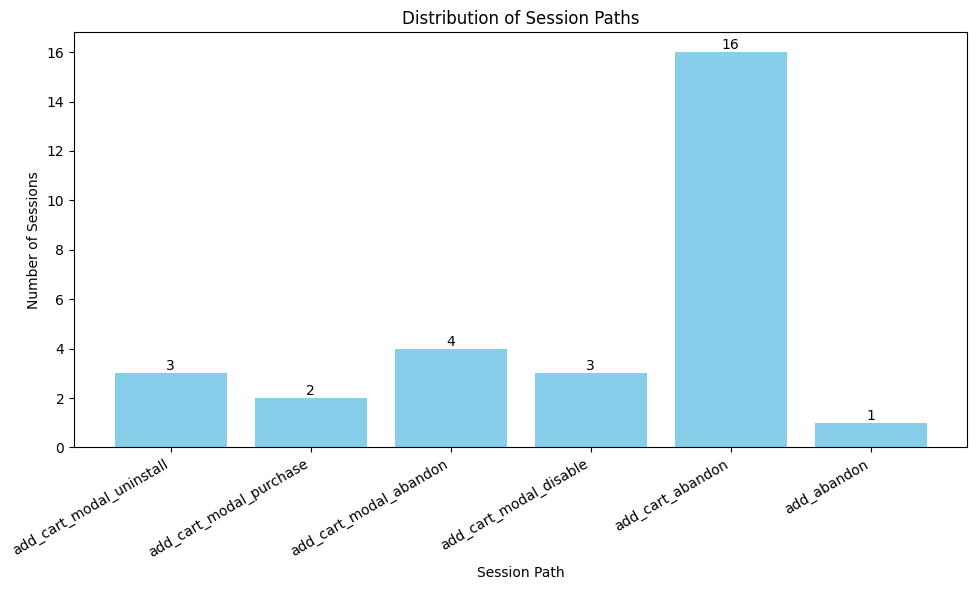

In [14]:

import matplotlib.pyplot as plt

# Prepare data for plotting
labels = list(path_counts.keys())
values = list(path_counts.values())

plt.figure(figsize=(10, 6))
bars = plt.bar(labels, values, color='skyblue')

# Add value labels on top of bars
for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(value),
                ha='center', va='bottom', fontsize=10)

plt.title('Distribution of Session Paths')
plt.xlabel('Session Path')
plt.ylabel('Number of Sessions')
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()


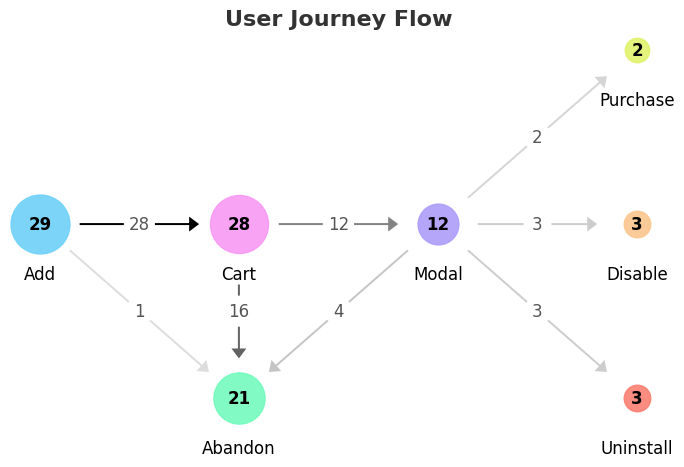

In [16]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

# Create a directed graph
G = nx.DiGraph()

# Define the possible states (nodes)
states = ['add', 'cart', 'modal', 'purchase', 'disable', 'uninstall', 'abandon']
for state in states:
    G.add_node(state)

# Add edges based on the path counts
for path, count in path_counts.items():
    if count > 0:  # Only consider paths that have occurred
        steps = path.split('_')
        for i in range(len(steps)-1):
            # Add edge from current step to next step
            if G.has_edge(steps[i], steps[i+1]):
                # Increment weight if edge exists
                G[steps[i]][steps[i+1]]['weight'] += count
            else:
                # Create new edge with weight
                G.add_edge(steps[i], steps[i+1], weight=count)

# Calculate node sizes based on total frequency
node_counts = {node: 0 for node in states}
for path, count in path_counts.items():
    steps = path.split('_')
    for step in steps:
        if step in node_counts:
            node_counts[step] += count

# Create a clean, minimal figure with white background
plt.figure(figsize=(7, 5), facecolor='white')

colors = ['salmon', '#F899F3', '#73FABD', '#6ED1F8','#E0F26D',  '#106ED3', '#6ED1F8']


# Define a nice pastel color palette
pastel_colors = {
    'add': '#6ED1F8',      # Light periwinkle 
    'cart': '#F899F3',  # Light peach
    'modal': '#ad9dfa',    # Light lime
    'purchase': '#E0F26D',  # Light mint
    'disable': '#fac68e',   # Light salmon
    'uninstall': 'salmon', 
    'abandon': '#73FABD',  # Light coral
}

# Define edge color (soft gray)
edge_color = '#000'

# Define node positions in a clear horizontal flow layout
positions = {
    'add': (0, 0),
    'cart': (2, 0),
    'modal': (4, 0),
    'abandon': (2, -1.75),
    'purchase': (6, 1.75),
    'disable': (6, 0),
    'uninstall': (6, -1.75),
}

# Normalize edge widths for better visualization
max_edge_weight = max([G[u][v]['weight'] for u, v in G.edges()])
edge_widths = [1.5 + (G[u][v]['weight'] / max_edge_weight) * 4 for u, v in G.edges()]

# Normalize node sizes
max_node_count = max(node_counts.values())
node_sizes = {node: 200 + (count / max_node_count) * 1600 for node, count in node_counts.items()}

# Draw nodes with custom colors and sizes
for node in G.nodes():
    nx.draw_networkx_nodes(
        G, positions, 
        nodelist=[node],
        node_size=node_sizes[node],
        node_color=pastel_colors[node],
        linewidths=1,
        alpha=0.9
    )


for u, v, data in G.edges(data=True):
    # Calculate normalized weight for edge thickness
    normalized_weight = data.get('weight', 1)
    normalized_weight = 1.5 + (normalized_weight / max_edge_weight) * 4

    # Calculate direction vector
    dx = positions[v][0] - positions[u][0]
    dy = positions[v][1] - positions[u][1]

    # Calculate vector length
    length = (dx**2 + dy**2)**0.5

    # Normalize direction vector
    if length > 0:
        dx_norm = dx / length
        dy_norm = dy / length
    else:
        dx_norm = 0
        dy_norm = 0

    offset = 0.4

    # Adjust start and end points to start and end 0.3 units from node centers
    start = [positions[u][0] + offset * dx_norm, positions[u][1] + offset * dy_norm]
    delta = [dx - offset*2 * dx_norm, dy - offset*2 * dy_norm]

    # Set line width and alpha based on weight
    line_width = 0.01 * data.get('weight', 1) / max_edge_weight * 5
    line_alpha = 0.1 + 0.9 * data.get('weight', 1) / max_edge_weight  # Vary alpha between 0.6 and 1.0

    # Draw curved arrows
    plt.arrow(start[0], start[1], delta[0], delta[1],
        head_width=0.15,
        head_length=0.1,
        fc=edge_color,
        ec=edge_color,
        alpha=line_alpha,
        linewidth=0,
        length_includes_head=True,
        width=0.02,                 # width of arrow body
    )

# Add elegant, clean labels to nodes
for node, (x, y) in positions.items():
    plt.text(
        x, y-0.5,
#        f"{node.capitalize()}\n({node_counts[node]})",
        node.capitalize(),
        fontsize=12,
        ha='center',
        va='center',
        fontfamily='sans-serif',
        fontweight='medium',
        bbox=dict(
            boxstyle="round,pad=0.1",
            fc="white",
            ec="none",
            alpha=1
        )
    )

    plt.text(
        x, y,
        node_counts[node],
        fontsize=12,
        #color='white',
        ha='center',
        va='center',
        fontfamily='sans-serif',
        fontweight='semibold',
    )

# Add edge labels using a cleaner approach
for u, v, data in G.edges(data=True):
    x1, y1 = positions[u]
    x2, y2 = positions[v]
    # Position labels slightly off the direct line
    label_pos_x = (x1 + x2) / 2
    label_pos_y = (y1 + y2) / 2
    

    plt.text(
        label_pos_x, label_pos_y,
        str(data['weight']),
        fontsize=12,
        ha='center',
        va='center',
        fontfamily='sans-serif',
        color='#555555',
        bbox=dict(
            boxstyle="circle,pad=0.3",
            fc="white",
            ec="none",
            alpha=1
        )
    )

# Add a clean, minimal title
plt.text(
    3, 2,
    'User Journey Flow',
    fontsize=16,
    ha='center',
    fontfamily='sans-serif',
    fontweight='bold',
    color='#333333'
)

# Remove axes completely
plt.axis('off')
plt.tight_layout()

# Set equal aspect ratio to make the graph more balanced
plt.gca().set_aspect('equal', adjustable='datalim')
plt.savefig('plots/user_journey_flow.png', dpi=300, bbox_inches='tight')

plt.show()